### Load Library

In [1]:
import os
import re
import logging
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment


### Load Dataset

In [2]:
# load data
df = pd.read_csv('data/songs_wav.csv', sep=",")

df.head()

,title,nama_lagu,region,keyword,duration,url,path,wav_path
0,Bungong Jeumpa | Lirik dan Terjemahan | Lagu D...,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,243,https://www.youtube.com/watch?v=lAVi2OE2bRY,datasets/songs/bungong_jeumpa_lirik_dan_terjem...,datasets/wav_songs/bungong_jeumpa_lirik_dan_te...
1,VIDEO LIRIK- BUNGONG JEUMPA,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,264,https://www.youtube.com/watch?v=tgc0dBKcqhE,datasets/songs/video_lirik_bungong_jeumpa.mp3,datasets/wav_songs/video_lirik_bungong_jeumpa.wav
2,Bungong Jeumpa - Putri Ariani Cover (Lagu Daer...,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,160,https://www.youtube.com/watch?v=RjI7W_XmzLM,datasets/songs/bungong_jeumpa_putri_ariani_cov...,datasets/wav_songs/bungong_jeumpa_putri_ariani...
3,Bungong Jeumpa,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,259,https://www.youtube.com/watch?v=_M1ZNoY99nk,datasets/songs/bungong_jeumpa.mp3,datasets/wav_songs/bungong_jeumpa.wav
4,Bungong Jeumpa - Tania,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,218,https://www.youtube.com/watch?v=ZfZxIR9vRmk,datasets/songs/bungong_jeumpa_tania.mp3,datasets/wav_songs/bungong_jeumpa_tania.wav


### Data Preprocessing

In [6]:
def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

split_result = []

def split_songs_to_segments(df, output_base_folder='datasets/30s_segments'):
    for index, row in df.iterrows():
        wav_path = row['wav_path']
        nama_lagu = row['nama_lagu']
        
        os.makedirs(f"{output_base_folder}/{normalized_yt_title(nama_lagu)}", exist_ok=True)
        
        audio = AudioSegment.from_wav(wav_path)
        total_duration = len(audio) / 1000
        segment_duration = 30
        num_segments = int(total_duration // segment_duration)
        
        for i in range(num_segments):
            start_time = i * segment_duration * 1000 
            end_time = (i + 1) * segment_duration * 1000
            segment = audio[start_time:end_time]
            
            segment_file = f"{output_base_folder}/{normalized_yt_title(nama_lagu)}/segment_{index}_{i}.wav"
            segment.export(segment_file, format="wav")
            
            split_result.append({
                'title': nama_lagu,
                '30s_path': segment_file
            })
        print(f"Saved {num_segments} segments for {nama_lagu} at: {output_base_folder}/{normalized_yt_title(nama_lagu)}")
        

In [7]:
split_songs_to_segments(df)

Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 5 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 7 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 6 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 8 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 13 segments for Bungong Jeumpa at: datasets/30s_segments/bungong_jeumpa
Saved 9 segments for Mecepat – Cepetan at: datasets/30s_segments/mecepat_cepetan
Saved 4 segments for Mecepat – Cepetan at: datasets/30s_segments/mecepat_cepetan
Saved 9 segments for Mecepat – Cepetan at: datasets/30s_segments/me

In [9]:
# save split result to csv
split_result_df = pd.DataFrame(split_result)
split_result_df.to_csv('data/30s_segments.csv', index=False)

### Feature Extraction

In [11]:
df_res = pd.read_csv('data/30s_segments.csv', sep=",")
df_res.head()

,title,30s_path
0,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...
1,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...
2,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...
3,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...
4,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...


In [32]:
# extract the feature using mfcc
def mfcc_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=12)
        mfccs_processed = np.mean(mfccs.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return mfccs_processed

def chroma_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path) 
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_processed = np.mean(chroma.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return chroma_processed

def mel_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path) 
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_processed = np.mean(mel.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return mel_processed

def combined_features(file_path):
    mfcc = mfcc_features(file_path)
    chroma = chroma_features(file_path)
    # mel = mel_features(file_path)
    
    return np.concatenate((mfcc, chroma))

In [33]:
# df_res['features'] = df_res['30s_path'].apply(combined_features)
# df_res['mfcc_features'] = df_res['30s_path'].apply(mfcc_features)
df_res['mfcc_12_features'] = df_res['30s_path'].apply(combined_features)

In [45]:
df_res.to_csv('data/30s_segments_features.csv', index=False)
df_res.head()

,title,30s_path,mfcc_features,mfcc_12_features
0,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...,"[-145.76633, 73.25051, 17.235668, 27.067945, 7...","[-145.76633, 73.25051, 17.235668, 27.067945, 7..."
1,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...,"[-94.453255, 85.354416, 19.829857, 29.550518, ...","[-94.453255, 85.354416, 19.829857, 29.550518, ..."
2,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...,"[-101.57153, 81.89458, 18.537878, 31.281668, 3...","[-101.57153, 81.89458, 18.537878, 31.281668, 3..."
3,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...,"[-97.65199, 88.235756, 17.676033, 23.640873, 3...","[-97.65199, 88.235756, 17.676033, 23.640873, 3..."
4,Bungong Jeumpa,datasets/30s_segments/bungong_jeumpa/segment_0...,"[-97.441696, 77.95034, 13.51779, 30.438295, 3....","[-97.441696, 77.95034, 13.51779, 30.438295, 3...."


In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

label_encoder = LabelEncoder()

X = np.array(df_res['mfcc_features'].tolist())
y = label_encoder.fit_transform(df_res['title'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (6299, 40)
X_test shape: (1575, 40)


In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Define the model
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

/home/reiaslite/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 512)            │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 103)            │        13,287 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,087 (789.40 KB)

 Trainable params: 200,295 (782.40 KB)

 Non-trainable params: 1,792 (7.00 KB)

In [50]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0392 - loss: 4.8704 - val_accuracy: 0.0762 - val_loss: 4.4944
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1373 - loss: 4.0193 - val_accuracy: 0.3010 - val_loss: 3.4051
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2494 - loss: 3.4605 - val_accuracy: 0.3771 - val_loss: 2.9122
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3085 - loss: 3.0574 - val_accuracy: 0.4222 - val_loss: 2.6220
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3878 - loss: 2.6833 - val_accuracy: 0.4857 - val_loss: 2.3435
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4285 - loss: 2.4514 - val_accuracy: 0.5340 - val_loss: 2.0881
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4755 - loss: 2.2325 - val_accuracy: 0.5917 - val_loss: 1.8549
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5139 - loss: 2.0387 - val_accuracy: 0.6178 - 

In [51]:
train_hist = pd.DataFrame(history.history)
train_hist['epoch'] = history.epoch
train_hist.tail()

,accuracy,loss,val_accuracy,val_loss,epoch
95,0.851722,0.442681,0.843175,0.532400,95
96,0.849182,0.443380,0.841270,0.536643,96
97,0.849659,0.440783,0.843175,0.542529,97
98,0.841562,0.469303,0.843175,0.529385,98
99,0.844896,0.444033,0.847619,0.547827,99


Test Accuracy: 84.76%


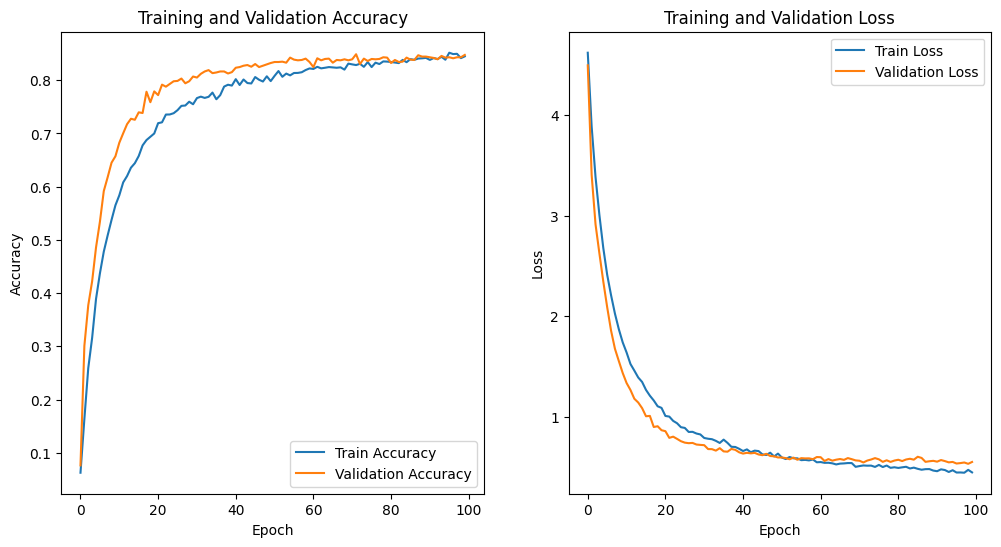

In [52]:
# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc * 100:.2f}%")

# plot the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [53]:
# Get predictions
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
test_accuracy = np.sum(y_pred_classes == y_test) / len(y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 84.76%


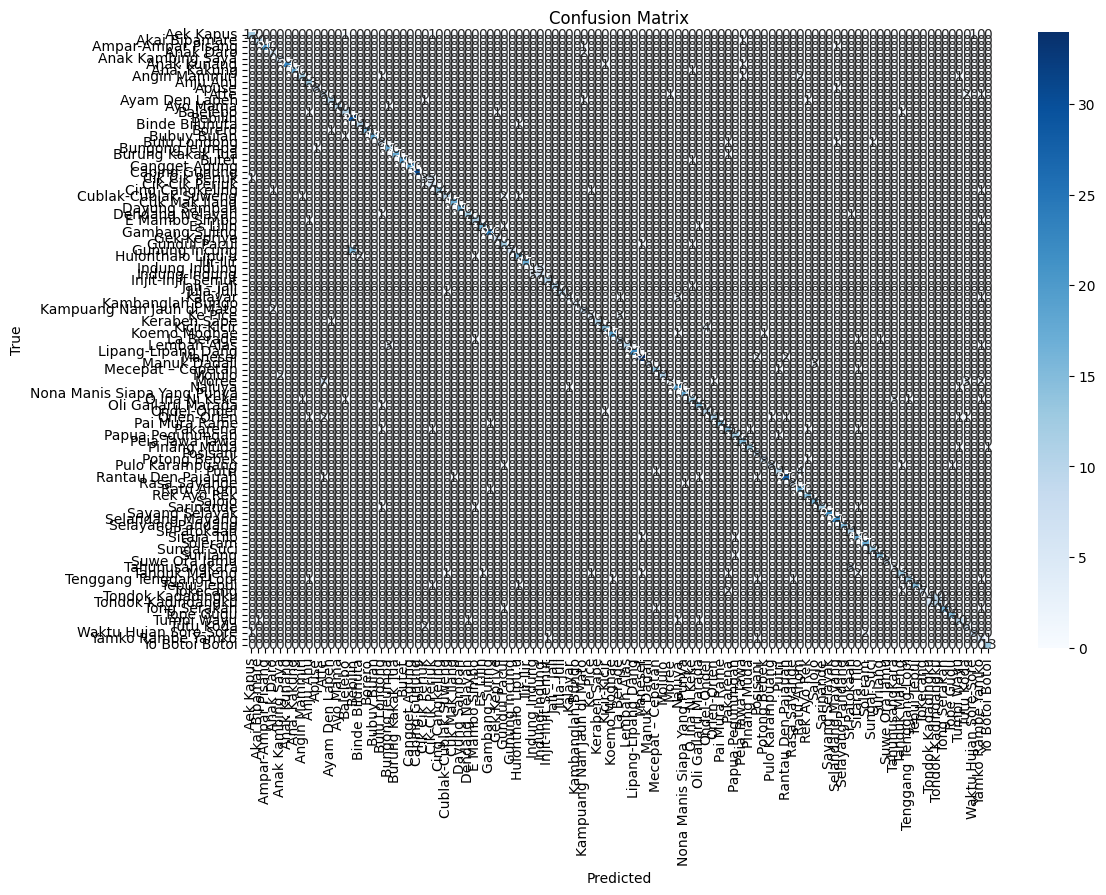

In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [28]:
from pydub import AudioSegment
from io import BytesIO

def convert_to_wav(audio_path):
    audio = AudioSegment.from_file(audio_path)
    wav_io = BytesIO()
    audio.export(wav_io, format="wav")
    wav_io.seek(0)
    return wav_io

# predict
def predict_song_genre(model, file_path):
    # Extract features
    wav = convert_to_wav(file_path)
    features = combined_features(wav)
    
    if features is not None:
        # Make prediction
        pred_features = features.reshape(1, -1)
        pred = model.predict(pred_features)
        pred_class = np.argmax(pred)
        
        # Get the predicted class label
        predicted_label = label_encoder.classes_[pred_class]
        
        # Get the predicted class probability
        pred_prob = pred[0][pred_class]
        
        return predicted_label, pred_prob
    else:
        return None

In [ ]:
# Test the prediction function
file_path = 'datasets/test/men_sahang_lah_mirah_lirik_lagu_bangka_belitung.mp3'
predicted_genre, pred_prob = predict_song_genre(model, file_path)
print(f"Predicted Genre: {predicted_genre} with probability: {pred_prob:.2f}")


In [ ]:
import tensorflowjs as tfjs

# save model
# model.save('model/my_model.h5')
# tf.keras.models.save_model(model, 'model/my_model.h5')

# # load model
# saved_model = tf.keras.models.load_model('best_model.keras')

# # Save the model in TensorFlow.js format
# tfjs.converters.save_keras_model(saved_model, 'model/tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [35]:
# load model
model = tf.keras.models.load_model('best_model.keras')